In [47]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [28]:
def clean_dataset(df):
    
    variables_to_remove = ['OP_CARRIER_FL_NUM', 'DEP_TIME','ARR_TIME','TAXI_OUT', 'WHEELS_OFF','WHEELS_ON','TAXI_IN', 
                           'CANCELLED', 'CANCELLATION_CODE','DIVERTED','AIR_TIME','CARRIER_DELAY','WEATHER_DELAY',
                           'NAS_DELAY', 'SECURITY_DELAY','LATE_AIRCRAFT_DELAY','CRS_ELAPSED_TIME','ACTUAL_ELAPSED_TIME',
                           'Unnamed: 27','Unnamed: 0']

    df.drop(variables_to_remove, axis = 1, inplace = True)

    df=df.rename(columns={'FL_DATE':'DATE','OP_CARRIER':'AIRLINE','DEST':'DESTIN',
                    'CRS_DEP_TIME':'SCHED_DEPARTURE','DEP_DELAY':'DEPARTURE_DELAY',
                    'CRS_ARR_TIME':'SCHED_ARRIVAL','ARR_DELAY':'ARRIVAL_DELAY'})

    df.dropna(inplace = True)
    
    df['DATE'] = pd.to_datetime(df['DATE'], format = '%Y-%m-%d', errors = 'coerce')
    
    return df


def format_hour(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if chaine == 2400: chaine = 0
        chaine = "{0:04d}".format(int(chaine))
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure

def combine_date(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
    
def transform_hour(df):
    df['SCHED_DEPARTURE'] = df['SCHED_DEPARTURE'].apply(format_hour)
    df['SCHED_ARRIVAL'] = df['SCHED_ARRIVAL'].apply(format_hour)
    
    return df

def create_flight_time(df):    
    lista=[]
    for i,v in df[['DATE','SCHED_DEPARTURE']].iterrows() :   #iteration over rows
    
        try :
            lista.append(datetime.datetime.combine(df['DATE'][i],df['SCHED_DEPARTURE'][i]))
        except:
            lista.append('error')        #if something goes wrong lista appens 'error'

    indices = [i for i, x in enumerate(lista) if x == "error"]   #test of lista to see if it'ok
    print ('Errors during data transformation :  ', len(indices))

    df['DATE_TIME']=lista
    return df

def percentile(df):
    df['DELAY_PERCENTILE']=df.ARRIVAL_DELAY.rank(pct=True)
    
    return df

def airline_name(df):
    
    df["AIRLINE_NAME"]=df.apply(lambda x: airlines.loc
                           [airlines['CODE'] == x["AIRLINE"],"AIRLINE"].values[0],axis=1)
    return df

def geo (df):
    df=pd.merge(df,airports[['IATA_CODE','LATITUDE','LONGITUDE']],left_on='ORIGIN', right_on='IATA_CODE')
    df=df.rename(columns={'LATITUDE':'OR_LATITUDE','LONGITUDE':'OR_LONGITUDE'})
   
    df=pd.merge(df,airports[['IATA_CODE','LATITUDE','LONGITUDE']],left_on='DESTIN', right_on='IATA_CODE')
    df=df.rename(columns={'LATITUDE':'DEST_LATITUDE','LONGITUDE':'DEST_LONGITUDE'})
    
    return df

def drop_code (df):
    variables_to_remove=['IATA_CODE_x','IATA_CODE_y']
    df=df.drop(variables_to_remove,axis = 1)
    return df

def outlier (df):
    #Outliers 
    # Drop'ARRIVAL_DELAY'>300 and 'ARRIVAL_DELAY'<-50
    outlier1 = df['ARRIVAL_DELAY']>300
    outrmv=df.index[outlier1].tolist()
    df=df.drop(outrmv)
    outlier2 = df['ARRIVAL_DELAY']<-50
    outrmv=df.index[outlier2].tolist()
    df=df.drop(outrmv)
    return df

def classes (df):
    if df['ARRIVAL_DELAY']<15:
        delay=0
    elif df['ARRIVAL_DELAY']<60:     
        delay=1
    elif df['ARRIVAL_DELAY']<180:
        delay=2
    else:
        delay=3
    return delay

def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

In [5]:
airports = pd.read_csv("dict/airports.csv")
airlines = pd.read_csv('dict/allairlines.csv', sep=';')
airlines_dict = airlines.set_index('CODE')['AIRLINE'].to_dict()
identify_airport = airports.set_index('IATA_CODE')['AIRPORT'].to_dict()
latitude_airport = airports.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = airports.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [6]:
df= pd.read_csv("data/2014.csv")
df_rnd=df.sample(frac = 0.1)
df_rnd.to_csv('sample/sample_2014.csv')

In [7]:
# Primero especificamos un patrón del archivo y lo pasamos como parámetro en la función glob
csv_files = glob.glob('sample/*.csv')
#csv_files = glob.glob('data/*.csv')
# Mostrar el archivo csv_files, el cual es una lista de nombres
print(csv_files)

['sample\\sample_2014.csv']


In [8]:
list_data = []
p = Path('clean/')
# Escribimos un loop que irá a través de cada uno de los nombres de archivo 
# Aplicamos las funciones en el bucle

for filename in csv_files:
    data = pd.read_csv(filename)
    #Cleaning
    data = clean_dataset(data)
    #Datetime Transform
    data = transform_hour(data)
    data = create_flight_time (data)
    #Outliers
    data = outlier(data)
    #Percentile
    data = percentile(data)
    #Airlines names
    data = airline_name(data)
    #Geo
    data = geo(data)
    data = drop_code(data)
    #Saving
    data.to_csv((Path(p, filename)), index=False)
    list_data.append(data)

Errors during data transformation :   0


In [9]:
list_data[0].head(20)

,DATE,AIRLINE,ORIGIN,DESTIN,SCHED_DEPARTURE,DEPARTURE_DELAY,SCHED_ARRIVAL,ARRIVAL_DELAY,DISTANCE,DATE_TIME,DELAY_PERCENTILE,AIRLINE_NAME,OR_LATITUDE,OR_LONGITUDE,DEST_LATITUDE,DEST_LONGITUDE
0,2014-06-28,WN,MCI,SEA,07:30:00,16.0,09:20:00,14.0,1489.0,2014-06-28 07:30:00,0.777717,Southwest Airlines Co.,39.29761,-94.71391,47.44898,-122.30931
1,2014-09-14,AS,MCI,SEA,16:15:00,-9.0,17:57:00,-15.0,1489.0,2014-09-14 16:15:00,0.154012,Alaska Airlines Inc.,39.29761,-94.71391,47.44898,-122.30931
2,2014-08-26,AS,MCI,SEA,16:15:00,-6.0,17:57:00,-8.0,1489.0,2014-08-26 16:15:00,0.341182,Alaska Airlines Inc.,39.29761,-94.71391,47.44898,-122.30931
3,2014-06-30,WN,MCI,SEA,07:55:00,3.0,09:45:00,12.0,1489.0,2014-06-30 07:55:00,0.758667,Southwest Airlines Co.,39.29761,-94.71391,47.44898,-122.30931
4,2014-03-10,AS,MCI,SEA,16:45:00,-6.0,18:35:00,-3.0,1489.0,2014-03-10 16:45:00,0.489316,Alaska Airlines Inc.,39.29761,-94.71391,47.44898,-122.30931
5,2014-03-24,AS,MCI,SEA,16:45:00,-11.0,18:35:00,11.0,1489.0,2014-03-24 16:45:00,0.748145,Alaska Airlines Inc.,39.29761,-94.71391,47.44898,-122.30931
6,2014-03-28,AS,MCI,SEA,16:45:00,-1.0,18:35:00,3.0,1489.0,2014-03-28 16:45:00,0.631801,Alaska Airlines Inc.,39.29761,-94.71391,47.44898,-122.30931
7,2014-04-07,AS,MCI,SEA,16:45:00,-1.0,18:30:00,-3.0,1489.0,2014-04-07 16:45:00,0.489316,Alaska Airlines Inc.,39.29761,-94.71391,47.44898,-122.30931
8,2014-09-22,AS,MCI,SEA,16:15:00,4.0,17:57:00,9.0,1489.0,2014-09-22 16:15:00,0.724849,Alaska Airlines Inc.,39.29761,-94.71391,47.44898,-122.30931
9,2014-03-13,AS,MCI,SEA,16:45:00,10.0,18:35:00,8.0,1489.0,2014-03-13 16:45:00,0.712003,Alaska Airlines Inc.,39.29761,-94.71391,47.44898,-122.30931


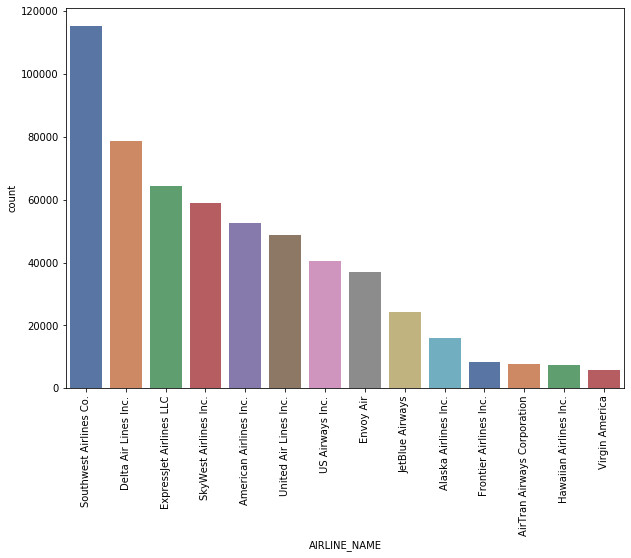

In [10]:
#AIRLINE DECISION
#
plt.figure(figsize=(10,7))
g=sns.countplot(x='AIRLINE_NAME', data=list_data[0], palette="deep", order = list_data[0]['AIRLINE_NAME'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(),rotation=90);

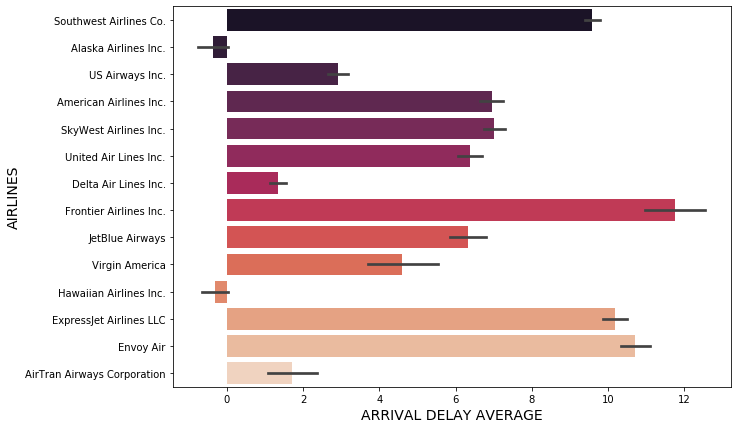

In [11]:
# AIRLINE DELAY AVERAGE
plt.figure(figsize=(10,7))
ax1=sns.barplot(y="AIRLINE_NAME", x="ARRIVAL_DELAY",data=list_data[0],palette='rocket')
plt.xlabel('ARRIVAL DELAY AVERAGE', fontsize=14)
plt.ylabel('AIRLINES', fontsize=14)
plt.show()

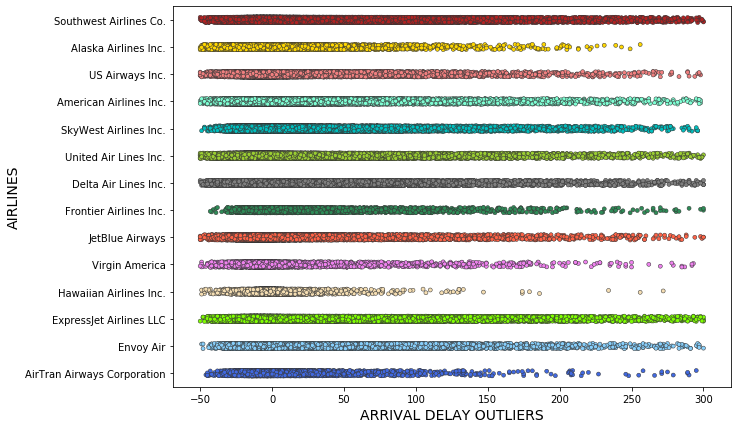

<Figure size 720x504 with 0 Axes>

In [12]:
# CHECKING OUTLIERS
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
plt.figure(figsize=(10,7))
ax2=sns.stripplot(y="AIRLINE_NAME", x="ARRIVAL_DELAY", size = 4, palette = colors,
                    data=list_data[0], linewidth = 0.5,  jitter=True)
plt.xlabel('ARRIVAL DELAY OUTLIERS', fontsize=14)
plt.ylabel('AIRLINES', fontsize=14)
plt.figure(figsize=(10,7))
plt.show()

In [13]:
# American Airlines (AA)
df_AA=list_data[0][list_data[0]['AIRLINE']=='AA']

In [14]:
variables_to_remove=['AIRLINE','AIRLINE_NAME','OR_LATITUDE', 'OR_LONGITUDE', 'DEST_LATITUDE', 
                 'DEST_LONGITUDE','DEPARTURE_DELAY']
df_AA=df_AA.drop(variables_to_remove, axis=1)

In [15]:
df_AA.head(100)

,DATE,ORIGIN,DESTIN,SCHED_DEPARTURE,SCHED_ARRIVAL,ARRIVAL_DELAY,DISTANCE,DATE_TIME,DELAY_PERCENTILE
59,2014-07-25,PHX,SEA,13:50:00,16:41:00,-16.0,1107.0,2014-07-25 13:50:00,0.133823
104,2014-07-27,PHX,SEA,13:50:00,16:41:00,-16.0,1107.0,2014-07-27 13:50:00,0.133823
166,2014-08-01,PHX,SEA,13:50:00,16:41:00,3.0,1107.0,2014-08-01 13:50:00,0.631801
354,2014-07-08,PHX,SEA,13:50:00,16:41:00,22.0,1107.0,2014-07-08 13:50:00,0.834396
430,2014-07-15,PHX,SEA,13:50:00,16:41:00,53.0,1107.0,2014-07-15 13:50:00,0.927662
...,...,...,...,...,...,...,...,...,...
785,2014-04-22,DFW,SEA,12:40:00,15:00:00,-13.0,1660.0,2014-04-22 12:40:00,0.200374
786,2014-07-16,DFW,SEA,08:00:00,10:00:00,13.0,1660.0,2014-07-16 08:00:00,0.768417
787,2014-12-12,DFW,SEA,15:45:00,18:05:00,-30.0,1660.0,2014-12-12 15:45:00,0.012276
789,2014-11-08,DFW,SEA,20:35:00,23:00:00,-1.0,1660.0,2014-11-08 20:35:00,0.542586


In [16]:
df_AA['DATE_TIME']=pd.to_datetime(df_AA['DATE_TIME'], format= '%Y-%m-%d %H:%M:%S')
df_AA['MONTH']=[ x.month for x in df_AA['DATE_TIME']]
df_AA['HOUR']=[ x.hour for x in df_AA['DATE_TIME']]

#to date_time
df_AA['SCHEDULED_DEPARTURE']=pd.to_datetime(df_AA['SCHED_DEPARTURE'], format= '%H:%M:%S') #to date_time
conversion = lambda x:x.hour*3600+x.minute*60+x.second 
df_AA['SCHEDULED_DEPARTURE']= np.array([conversion(s) for s in df_AA['SCHED_DEPARTURE']]) #conversion to seconds


df_AA_DATE=df_AA.groupby(df_AA['DATE_TIME']).mean()

df_AA_DATE.head(100)

,ARRIVAL_DELAY,DISTANCE,DELAY_PERCENTILE,MONTH,HOUR,SCHEDULED_DEPARTURE
DATE_TIME,,,,,,
2014-01-01 00:05:00,-20.0,2330.0,0.072555,1,0,300
2014-01-01 06:00:00,3.0,1033.0,0.538027,1,6,21600
2014-01-01 06:25:00,-10.5,467.5,0.278074,1,6,23100
2014-01-01 06:30:00,0.0,733.0,0.567226,1,6,23400
2014-01-01 06:35:00,-4.5,834.5,0.425357,1,6,23700
...,...,...,...,...,...,...
2014-01-01 21:10:00,15.0,432.0,0.786379,1,21,76200
2014-01-01 23:20:00,-17.0,1660.0,0.115637,1,23,84000
2014-01-01 23:35:00,25.0,2527.0,0.849402,1,23,84900


In [17]:
df_AA.head(100)

,DATE,ORIGIN,DESTIN,SCHED_DEPARTURE,SCHED_ARRIVAL,ARRIVAL_DELAY,DISTANCE,DATE_TIME,DELAY_PERCENTILE,MONTH,HOUR,SCHEDULED_DEPARTURE
59,2014-07-25,PHX,SEA,13:50:00,16:41:00,-16.0,1107.0,2014-07-25 13:50:00,0.133823,7,13,49800
104,2014-07-27,PHX,SEA,13:50:00,16:41:00,-16.0,1107.0,2014-07-27 13:50:00,0.133823,7,13,49800
166,2014-08-01,PHX,SEA,13:50:00,16:41:00,3.0,1107.0,2014-08-01 13:50:00,0.631801,8,13,49800
354,2014-07-08,PHX,SEA,13:50:00,16:41:00,22.0,1107.0,2014-07-08 13:50:00,0.834396,7,13,49800
430,2014-07-15,PHX,SEA,13:50:00,16:41:00,53.0,1107.0,2014-07-15 13:50:00,0.927662,7,13,49800
...,...,...,...,...,...,...,...,...,...,...,...,...
785,2014-04-22,DFW,SEA,12:40:00,15:00:00,-13.0,1660.0,2014-04-22 12:40:00,0.200374,4,12,45600
786,2014-07-16,DFW,SEA,08:00:00,10:00:00,13.0,1660.0,2014-07-16 08:00:00,0.768417,7,8,28800
787,2014-12-12,DFW,SEA,15:45:00,18:05:00,-30.0,1660.0,2014-12-12 15:45:00,0.012276,12,15,56700
789,2014-11-08,DFW,SEA,20:35:00,23:00:00,-1.0,1660.0,2014-11-08 20:35:00,0.542586,11,20,74100


In [18]:
le=LabelEncoder()
df_AA['ORIGIN_LABEL']=le.fit_transform(df_AA['ORIGIN'])
df_AA['DESTIN_LABEL']=le.fit_transform(df_AA['DESTIN'])

In [19]:
df_AA.head(100)

,DATE,ORIGIN,DESTIN,SCHED_DEPARTURE,SCHED_ARRIVAL,ARRIVAL_DELAY,DISTANCE,DATE_TIME,DELAY_PERCENTILE,MONTH,HOUR,SCHEDULED_DEPARTURE,ORIGIN_LABEL,DESTIN_LABEL
59,2014-07-25,PHX,SEA,13:50:00,16:41:00,-16.0,1107.0,2014-07-25 13:50:00,0.133823,7,13,49800,61,73
104,2014-07-27,PHX,SEA,13:50:00,16:41:00,-16.0,1107.0,2014-07-27 13:50:00,0.133823,7,13,49800,61,73
166,2014-08-01,PHX,SEA,13:50:00,16:41:00,3.0,1107.0,2014-08-01 13:50:00,0.631801,8,13,49800,61,73
354,2014-07-08,PHX,SEA,13:50:00,16:41:00,22.0,1107.0,2014-07-08 13:50:00,0.834396,7,13,49800,61,73
430,2014-07-15,PHX,SEA,13:50:00,16:41:00,53.0,1107.0,2014-07-15 13:50:00,0.927662,7,13,49800,61,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785,2014-04-22,DFW,SEA,12:40:00,15:00:00,-13.0,1660.0,2014-04-22 12:40:00,0.200374,4,12,45600,17,73
786,2014-07-16,DFW,SEA,08:00:00,10:00:00,13.0,1660.0,2014-07-16 08:00:00,0.768417,7,8,28800,17,73
787,2014-12-12,DFW,SEA,15:45:00,18:05:00,-30.0,1660.0,2014-12-12 15:45:00,0.012276,12,15,56700,17,73
789,2014-11-08,DFW,SEA,20:35:00,23:00:00,-1.0,1660.0,2014-11-08 20:35:00,0.542586,11,20,74100,17,73


In [20]:
le.fit(df_AA['ORIGIN'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'ABQ': 0, 'ANC': 1, 'ATL': 2, 'AUS': 3, 'BDL': 4, 'BHM': 5, 'BNA': 6, 'BOS': 7, 'BWI': 8, 'CLE': 9, 'CLT': 10, 'CMH': 11, 'COS': 12, 'CRP': 13, 'DAY': 14, 'DCA': 15, 'DEN': 16, 'DFW': 17, 'DSM': 18, 'DTW': 19, 'EGE': 20, 'ELP': 21, 'EWR': 22, 'FAT': 23, 'FLL': 24, 'GUC': 25, 'HDN': 26, 'HNL': 27, 'HOU': 28, 'HSV': 29, 'IAD': 30, 'IAH': 31, 'ICT': 32, 'IND': 33, 'JAC': 34, 'JAX': 35, 'JFK': 36, 'KOA': 37, 'LAS': 38, 'LAX': 39, 'LBB': 40, 'LGA': 41, 'LIH': 42, 'LIT': 43, 'MCI': 44, 'MCO': 45, 'MEM': 46, 'MFE': 47, 'MIA': 48, 'MKE': 49, 'MSP': 50, 'MSY': 51, 'OGG': 52, 'OKC': 53, 'OMA': 54, 'ONT': 55, 'ORD': 56, 'ORF': 57, 'PBI': 58, 'PDX': 59, 'PHL': 60, 'PHX': 61, 'PIT': 62, 'PNS': 63, 'PSP': 64, 'RDU': 65, 'RIC': 66, 'RNO': 67, 'RSW': 68, 'SAN': 69, 'SAT': 70, 'SDF': 71, 'SEA': 72, 'SFO': 73, 'SJC': 74, 'SJU': 75, 'SLC': 76, 'SMF': 77, 'SNA': 78, 'STL': 79, 'STT': 80, 'STX': 81, 'TPA': 82, 'TUL': 83, 'TUS': 84, 'XNA': 85}


In [21]:
le.fit(df_AA['DESTIN'])
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'ABQ': 0, 'ANC': 1, 'ATL': 2, 'AUS': 3, 'BDL': 4, 'BHM': 5, 'BNA': 6, 'BOS': 7, 'BWI': 8, 'CLE': 9, 'CLT': 10, 'CMH': 11, 'COS': 12, 'CRP': 13, 'DAY': 14, 'DCA': 15, 'DEN': 16, 'DFW': 17, 'DSM': 18, 'DTW': 19, 'EGE': 20, 'ELP': 21, 'EWR': 22, 'FAT': 23, 'FLL': 24, 'GUC': 25, 'HDN': 26, 'HNL': 27, 'HOU': 28, 'HSV': 29, 'IAD': 30, 'IAH': 31, 'ICT': 32, 'IND': 33, 'JAC': 34, 'JAX': 35, 'JFK': 36, 'KOA': 37, 'LAS': 38, 'LAX': 39, 'LBB': 40, 'LGA': 41, 'LIH': 42, 'LIT': 43, 'MCI': 44, 'MCO': 45, 'MEM': 46, 'MFE': 47, 'MIA': 48, 'MKE': 49, 'MSP': 50, 'MSY': 51, 'MTJ': 52, 'OGG': 53, 'OKC': 54, 'OMA': 55, 'ONT': 56, 'ORD': 57, 'ORF': 58, 'PBI': 59, 'PDX': 60, 'PHL': 61, 'PHX': 62, 'PIT': 63, 'PNS': 64, 'PSP': 65, 'RDU': 66, 'RIC': 67, 'RNO': 68, 'RSW': 69, 'SAN': 70, 'SAT': 71, 'SDF': 72, 'SEA': 73, 'SFO': 74, 'SJC': 75, 'SJU': 76, 'SLC': 77, 'SMF': 78, 'SNA': 79, 'STL': 80, 'STT': 81, 'STX': 82, 'TPA': 83, 'TUL': 84, 'TUS': 85, 'XNA': 86}


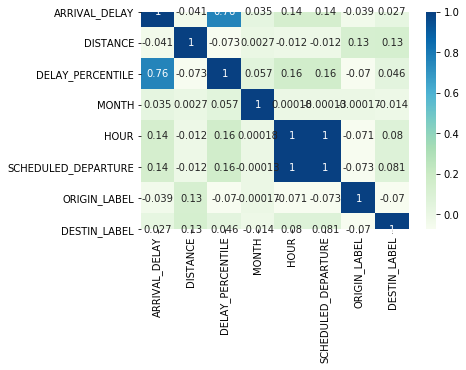

In [22]:
#CORRELATION MATRIX (Pearson Correlation)
corrmat=df_AA.corr()
ax = sns.heatmap(corrmat, annot=True, cmap="GnBu")

In [29]:
df_AA['DELAY LEVEL']=df_AA.apply(classes, axis=1)

In [32]:
df_AA.head()

,DISTANCE,MONTH,HOUR,SCHEDULED_DEPARTURE,ORIGIN_LABEL,DESTIN_LABEL,DELAY LEVEL
59,1107.0,7,13,49800,61,73,0
104,1107.0,7,13,49800,61,73,0
166,1107.0,8,13,49800,61,73,0
354,1107.0,7,13,49800,61,73,1
430,1107.0,7,13,49800,61,73,1


In [31]:
df_AA_class=df_AA.drop(['DATE','ORIGIN','DESTIN','SCHED_DEPARTURE',
                        'SCHED_ARRIVAL','DATE_TIME','DELAY_PERCENTILE','ARRIVAL_DELAY'], inplace=True, axis=1)

In [34]:
#CLASIFICACIÓN
#Random forest
#sample aleatorio de un año
#Separamos la columna con la información del delay_level
X = np.array(df_AA.drop(['DELAY LEVEL'],1))
y = np.array(df_AA['DELAY LEVEL'])

In [35]:
#Separamos los datos en train y test, con una proporción de un 70% y 30%, respectivamente.
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.3)

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
rnd_forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rnd_forest.fit(X_train, y_train)
y_pred_rnd_forest = rnd_forest.predict(X_test)

In [39]:
#Precisión en la clasificación de los valores de entrenamiento
acc_rnd_forest_train = round(rnd_forest.score(X_train, y_train) * 100, 2)
print (acc_rnd_forest_train)

84.64


In [40]:
# Precisión en la clasificación de los valores de test
acc_rnd_forest = accuracy_score(y_test, y_pred_rnd_forest)
print (acc_rnd_forest*100)

69.1848654139157


In [42]:
# Matriz de confusión
print(pd.crosstab(y_test, y_pred_rnd_forest, rownames=['Real'], colnames=['Predicted']))

Predicted      0     1    2   3
Real                           
0          10487  1245  427  37
1           2026   353  135   9
2            692   156   58   2
3            104    15    6   0


In [46]:
print(list(zip(X, rnd_forest.feature_importances_)))
joblib.dump(rnd_forest, 'randomforestmodel.pkl') 

[(array([1.107e+03, 7.000e+00, 1.300e+01, 4.980e+04, 6.100e+01, 7.300e+01]), 0.17399496349752114), (array([1.107e+03, 7.000e+00, 1.300e+01, 4.980e+04, 6.100e+01, 7.300e+01]), 0.28590133375851723), (array([1.107e+03, 8.000e+00, 1.300e+01, 4.980e+04, 6.100e+01, 7.300e+01]), 0.06893481353566255), (array([1.107e+03, 7.000e+00, 1.300e+01, 4.980e+04, 6.100e+01, 7.300e+01]), 0.23618850957184123), (array([1.107e+03, 7.000e+00, 1.300e+01, 4.980e+04, 6.100e+01, 7.300e+01]), 0.11561162314138565), (array([1.66e+03, 9.00e+00, 1.20e+01, 4.62e+04, 1.70e+01, 7.30e+01]), 0.11936875649507228)]


['randomforestmodel.pkl']

C:\Users\alex_\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.14136099 0.34652154 0.07374065 0.23094444 0.10357875 0.10385363]


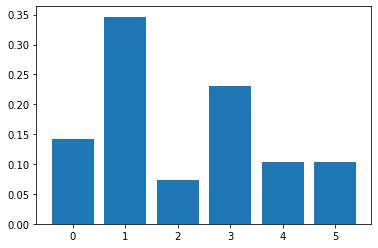

In [50]:
#Para obtener la importancia de cada variable inicializamos el  ExtraTreesClassifier
model = ExtraTreesClassifier()

#Ajustamos el modelo
model.fit(X_train,y_train)

#Pedimos que nos muestre la importancia de cada variable
print(model.feature_importances_)

#Para dibujar todos las variables con su importancia
from matplotlib import pyplot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()